# Installed Python libraries

In [167]:
! pip install pubchempy
! pip install rdkit
! pip install pandas
! pip install scikit-learn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


# All imports

In [169]:
import numpy as np
import pandas as pd

import pubchempy as pcp
from rdkit import Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors

import pickle


# Functions for collecting features from PubChem and RDKit and load models from files.

These are the same functions used in ModelTraining.ipynb

In [172]:
DESCRIPTOR_NAMES = [desc_name[0] for desc_name in Descriptors._descList]


# Get compound information from pubchem website for one compound name. It calls pubchem website so we need to be nice. First, when trying to collect information 
# for a large number of compounds, we cut them into smaller batches so that we do not burden the pubchem website. Second, this information only need to be collected once, 
# so we save the infomation with pickle and reuse it later without calling pubchem again.
def getCompounds(names):
    data = {}
    for chemical_name in names:
        compounds = pcp.get_compounds(chemical_name, 'name')
        data[chemical_name] = compounds
    return data


# The following functions get features from PubChem and RDKit. Function getFeatures() wrap all of them together.

# List of features collected from PubChem. Note some of features are in string format so we need to convert them to numbers later.
def getFeaturesFromPubChem(compound):
    x_dict = compound.to_dict()
    count_keys = ['atom_stereo_count', 'bond_stereo_count', 'charge', 'complexity', 'covalent_unit_count', 'defined_atom_stereo_count', 'defined_bond_stereo_count', 
              'exact_mass', 'h_bond_acceptor_count', 'h_bond_donor_count', 
              'heavy_atom_count', 
              'isotope_atom_count', 
              'molecular_weight', 'monoisotopic_mass', 
              'rotatable_bond_count', 'tpsa', 'undefined_atom_stereo_count', 'undefined_bond_stereo_count', 
              'volume_3d', 'xlogp']
    subset_dict = {key: x_dict[key] for key in count_keys}
    #print(subset_dict["exact_mass"])

    return subset_dict

# Collecting features from the RDKit library.
def getRdkitMoleculeFromPubChemCompound(compound):
    return Chem.MolFromInchi(compound.inchi) 

def getFeaturesFromChem(molelcule, descriptor_names=DESCRIPTOR_NAMES):
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    descriptors = calculator.CalcDescriptors(molelcule)

    descriptor_dict = dict(zip(DESCRIPTOR_NAMES, descriptors))

    return descriptor_dict

def getFeaturesFromRdkit(compound, descriptor_names=DESCRIPTOR_NAMES):
    molecule = getRdkitMoleculeFromPubChemCompound(compound)
    
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
    descriptors = calculator.CalcDescriptors(molecule)

    descriptor_dict = dict(zip(descriptor_names, descriptors))
    return descriptor_dict


# Combining features from both PubChem and RDKit
def getFeatures(compound):
    dict_1 = getFeaturesFromPubChem(compound);
    dict_2 = getFeaturesFromRdkit(compound, DESCRIPTOR_NAMES)
    return dict_1 | dict_2


# The following two functions are used to save/load compound and feature information to files so that we do not have to regenerate them every time we restart this notebook.

def save_object_to_disk(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)
        print("Python object has been saved to file.")

def load_object_from_disk(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        print("Python object has been loaded from file.")
        return data 

# L flos Data
Compounds in L flos are mostly collected from https://www.sciencedirect.com/science/article/pii/S2589377719300229#tbl3, which compiled more than 200 compounds
But I also added some from other papers. They are stored in lonicerae_tab1e1.tsv to lonicerae_tab1e5.tsv, and lonicerae_clean.txt.


In [176]:
# Compounds in lonicerae.
lonicerae_filenames = [
    "lonicerae_tab1e1.tsv",
    "lonicerae_tab1e2.tsv",
    "lonicerae_tab1e3.tsv",
    "lonicerae_tab1e4.tsv",
    "lonicerae_tab1e5.tsv"
]

lf_compound_names = []

for file_path in lonicerae_filenames:
    df = pd.read_csv(file_path, sep='\t')
    column_name = df.columns[0]  
    lf_compound_names.extend(df[column_name].tolist())
    
lonicerae_paper2_filename = 'lonicerae_clean.txt'
with open(lonicerae_paper2_filename, 'r') as file:
    lines = file.readlines()

lf_compound_names.extend(lines)

# Strip newline characters from each line. Also remove empty lines. Also change′ to '
lf_compound_names = [name.strip().replace('′','\'') for name in lf_compound_names if name.strip()]
lf_compound_names = [name.replace('β','beta') for name in lf_compound_names]
lf_compound_names = [name.replace('α','alpha') for name in lf_compound_names]

#print(len(lf_compound_names))

# remove duplicates
lf_compound_names = list(set(lf_compound_names))
print("total number of compound names identified from LF and LJF:", len(lf_compound_names))

lf_compound_names

total number of compound names identified from LF and LJF: 310


['Luteolin-5-O-beta-D-glucoside',
 'beta-amyrin acetate',
 "5-Hydroxy-7,4'-dimethoxyflavone",
 'Loniceracetalide B',
 '1-O-caffeoyl quinic acid',
 'p-hydroxy benzaldehyde',
 '5-Caffeoylquinic Acid',
 'Dodecan-1-ol',
 'Secologanoside',
 'Secologanin Dimethyl Acetal',
 '3,7-dimethyl-1,6-dien-3-ol',
 'Nerolidol',
 '1,10-decanediol',
 '9-octadecenoic acid methyl ester',
 'Secoxyloganin 7-Butyl Ester',
 'beta-daucosterol',
 'Isorhamnetin-3-O-beta-D-glucopyranoside',
 'Octan-1-ol',
 'Kaempferol',
 'Dimethyl Secologanoside',
 'Pentadec-14-enoic acid',
 'Octadeca-9,12,15-trienal',
 'Gentisic acid-5-O-beta-D-glucopyranoside',
 'Lonijaposide N',
 'Lonijaposide K',
 'Jaceosidin-7-O-neohesperidoside',
 'Hexadecan-1-ol',
 'Phenanthrane',
 'Lonimacranthoide I',
 'Palmitic acid',
 'Macranthoin G',
 'Hexaconsane',
 'Propaldehyde',
 'Loniphenyruviridoside B',
 'Decanoic acid',
 'Trans-ferulic acid',
 'Chlorogenic acid methyl ester',
 'Lonijapospiroside A',
 '(E,E)-2,4-decadien-1-al',
 'Ethyl myristate'

## Collect compounds info from PubChem and save it as pickle for future use

In [177]:
# Remove # to run the line of code. It retrieve compound info from PubChem based on name. It could be slow.
#lf_compounds = getCompounds(lf_compound_names)

In [61]:
# Save the compound
save_object_to_disk(lf_compounds, "lf_compounds.pkl")

Object data has been serialized and saved to file.


In [4]:
lf_compounds = load_object_from_disk("lf_compounds.pkl")

Object has been deserialized and loaded from file.


In [127]:
len(lf_compounds), len(lf_compound_names)

(310, 310)

In [178]:
# create a mapping between the iupac_name to name so that later we can use the shorter name when drawing images.
prediction_compounds_to_name = {item.iupac_name:i[0] for i in lf_compounds.items() for item in i[1]}
prediction_compounds_to_name

{'6,10,14-trimethylpentadecan-2-one': '6,10,14-trimethyl-2-Pentadecanone',
 '(E)-3-(4-hydroxy-3-methoxyphenyl)prop-2-enoic acid': 'Ferulic Acid',
 'decan-1-ol': '1-decanol',
 '(3R,4aS,8R,10aR)-3-ethenyl-3,4a,7,7,10a-pentamethyl-2,5,6,6a,8,9,10,10b-octahydro-1H-benzo[f]chromen-8-ol': 'Ribenol',
 'octadecane': 'Octadecane',
 'but-3-en-2-one': '3-buten-2-one',
 'benzyl benzoate': 'Benzyl benzoate',
 'methyl tetradecanoate': 'Methyl myristate',
 'ethyl dodecanoate': 'Ethyl laurate',
 '6,10,14-trimethylpentadecan-2-ol': '6,10,14-trimethyl-pentadecan-2-ol',
 '(Z)-octadec-9-enoic acid': 'Oleic acid',
 'decanal': 'Decanal',
 '(2S,3R,4S)-4-[(E)-2-[1-(carboxymethyl)pyridin-1-ium-3-yl]ethenyl]-3-ethenyl-2-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy-3,4-dihydro-2H-pyran-5-carboxylate': 'Lonijaposide K',
 '(2S,3R,4S)-3-ethenyl-4-[[(2R)-4-hydroxy-5-oxo-3-phenyl-2H-furan-2-yl]methyl]-2-[(2S,3R,4S,5S,6R)-3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxy-3,4-dihydro-2H-pyran-5-carbo

## Features using data from PubChem and RDKit

In [6]:
lf_compounds

{'Hexahydrofarnesyl acetone': [Compound(10408)],
 'Trans-ferulic acid': [Compound(445858)],
 '1-decanol': [Compound(8174)],
 'Dehydromorroniside': [],
 'Ribenol': [Compound(10447894)],
 'Deoxyoprolinoyiloganin A': [],
 'Octadecane': [Compound(11635)],
 '3-buten-2-one': [Compound(6570)],
 'L-Phenylalaninosecologanin C': [],
 '(E)-2-octanal': [],
 '2-undecyl-methyl cyclopropane pentanoic acid': [],
 'Benzyl benzoate': [Compound(2345)],
 '3,7,11,15-tetramethyl-2-hexadecan-1-ol': [],
 '6,7-dioxabicyclo[3.2.2] non-8-ene': [],
 '7-Epiloganin': [],
 'Methyl myristate': [Compound(31284)],
 'Ethyl laurate': [Compound(7800)],
 '6,10,14-trimethyl-pentadecan-2-ol': [Compound(530418)],
 "5-Hydroxy-7,3',4',5'-tetramethoxyflavone": [],
 '(E)-1-(2,6,6-trimethyl-1,3-cyclohexadiene-(1-yl)-2-buten-1-one': [],
 'Oleic acid': [Compound(445639)],
 'Decanal': [Compound(8175)],
 'Quercetin-7-O-beta-D-glucoside': [],
 'Lonijaposide K': [Compound(56599871)],
 'Loniphenyruviridoside D': [Compound(56598469)],
 '(

In [9]:
prediction_compounds = [item for i in lf_compounds.items() for item in i[1]]
print("number of compounds in the herb:", len(prediction_compounds))
prediction_features = [getFeatures(compound) for compound in prediction_compounds] 

df_X = pd.DataFrame(prediction_features)

# feature cleaning: some numbers are in string format, convert them to numbers
string_columns = df_X.select_dtypes(include='object').columns.tolist()
for i in string_columns:
    df_X[i] = pd.to_numeric(df_X[i])
    
# feature cleaning: replace NAN and INF with special values. They are rare in the data but cause errors if not replaced.
df_X.replace([np.nan], -1, inplace=True)
df_X.replace([np.inf], np.finfo(np.float32).max, inplace=True)
df_X.replace([-np.inf], np.finfo(np.float32).min, inplace=True)

# feature cleaning: some numbers in RDKit is too large for float32
df_X.loc[df_X['Ipc'] > 3.4028235e38, 'Ipc'] = np.finfo(np.float32).max    
   

number of compounds in the herb: 238


# Compound Screening/Prediction 
Use the model saved by ModelTraining.ipynb 

In [150]:
featureImportanceFinal = load_object_from_disk("model_balance_weight_featureImportanceFinal.pkl")

Object has been deserialized and loaded from file.


In [151]:
modelFinal = load_object_from_disk("model_balance_weight.pkl")

Object has been deserialized and loaded from file.


In [77]:
featureImportanceFinal["Feature"].tolist()

['SMR_VSA3',
 'fr_NH0',
 'NumAromaticHeterocycles',
 'undefined_atom_stereo_count',
 'fr_ether',
 'NumAliphaticHeterocycles',
 'qed',
 'fr_Ar_N',
 'NumRotatableBonds',
 'SMR_VSA10',
 'rotatable_bond_count',
 'BCUT2D_MWHI',
 'EState_VSA5',
 'EState_VSA7',
 'NumHeteroatoms',
 'BalabanJ',
 'FpDensityMorgan1',
 'EState_VSA2',
 'xlogp',
 'PEOE_VSA8',
 'SMR_VSA6',
 'NOCount',
 'SlogP_VSA3',
 'SMR_VSA1',
 'ExactMolWt',
 'VSA_EState5',
 'VSA_EState1',
 'FpDensityMorgan2',
 'exact_mass',
 'EState_VSA6',
 'SlogP_VSA1',
 'MinEStateIndex',
 'FpDensityMorgan3',
 'BertzCT',
 'VSA_EState4',
 'MolWt',
 'EState_VSA4',
 'BCUT2D_MWLOW',
 'SlogP_VSA6',
 'BCUT2D_LOGPLOW',
 'FractionCSP3',
 'EState_VSA10',
 'monoisotopic_mass',
 'NumValenceElectrons',
 'BCUT2D_MRLOW',
 'h_bond_acceptor_count',
 'BCUT2D_MRHI',
 'PEOE_VSA9',
 'SMR_VSA4',
 'PEOE_VSA7',
 'VSA_EState3',
 'NumHAcceptors',
 'Chi0v',
 'molecular_weight',
 'Chi1v',
 'tpsa',
 'Kappa1',
 'SPS',
 'fr_amide',
 'EState_VSA3',
 'Kappa3',
 'BCUT2D_LOGPHI',

## Generating prediction scores

In [91]:
Y_pred = modelFinal.predict_proba(X_pred)
Y_pred

array([[0.992     , 0.008     ],
       [0.882     , 0.118     ],
       [0.8742773 , 0.1257227 ],
       [0.98625932, 0.01374068],
       [0.96871843, 0.03128157],
       [0.94851864, 0.05148136],
       [0.988     , 0.012     ],
       [0.986     , 0.014     ],
       [0.986     , 0.014     ],
       [0.986     , 0.014     ],
       [0.97435277, 0.02564723],
       [0.856     , 0.144     ],
       [0.988     , 0.012     ],
       [0.988     , 0.012     ],
       [0.974     , 0.026     ],
       [0.81212379, 0.18787621],
       [0.984     , 0.016     ],
       [0.918     , 0.082     ],
       [0.986     , 0.014     ],
       [0.938     , 0.062     ],
       [0.97517754, 0.02482246],
       [0.98      , 0.02      ],
       [0.988     , 0.012     ],
       [0.872     , 0.128     ],
       [0.96      , 0.04      ],
       [0.99      , 0.01      ],
       [0.94213865, 0.05786135],
       [0.99045911, 0.00954089],
       [0.95613865, 0.04386135],
       [0.89454298, 0.10545702],
       [0.

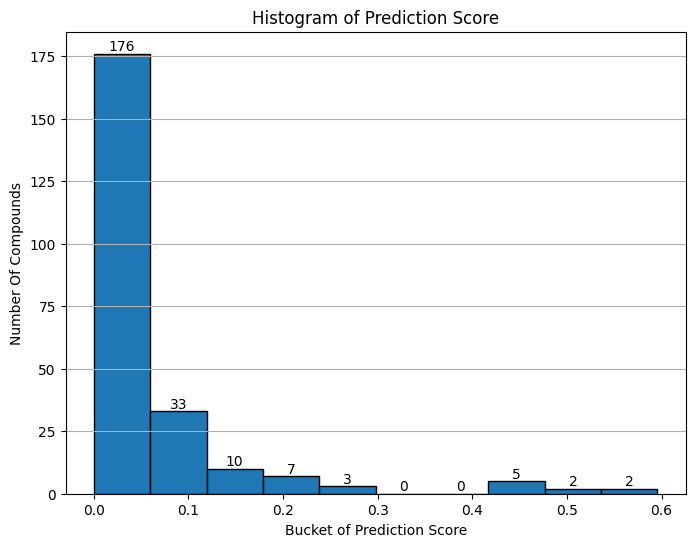

In [154]:
import pandas as pd
import matplotlib.pyplot as plt

df = featureImportanceFinal

# Plotting the histogram
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
prediction_scores = [i[1] for i in Y_pred] 

counts, bins, patches = plt.hist(prediction_scores, bins=10, edgecolor='black')  # `bins` controls the number of bins
plt.title('Histogram of Prediction Score')
plt.xlabel('Bucket of Prediction Score')
plt.ylabel('Number Of Compounds')
plt.grid(axis='y') # show only the horizontal grid line

# Add y-values on top of the bars
for count, patch in zip(counts, patches):
    plt.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)), 
             ha='center', va='bottom')

plt.savefig('acne_prediction_score_histogram.png')  # Save the plot as a PNG file
plt.show()

## Examine the compounds with top prediction scores

In [156]:
print(len(Y_pred))

238


[0.53092424 0.46907576]


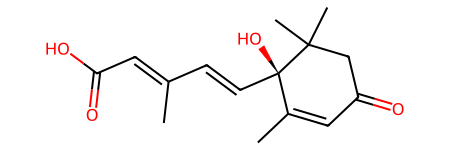

In [165]:
compounds_with_prediction = list(zip(prediction_compounds, Y_pred, prediction_features))


# sort by prediction score Y_pred[1]
compounds_with_prediction = sorted(compounds_with_prediction, key=lambda x: -x[1][1])

#best_compound = [c for c in compounds_with_prediction if c[1][1] >= 0.20]
#best_compound[0][0].synonyms

i = 7
best_molecule = getRdkitMoleculeFromPubChemCompound(compounds_with_prediction[i][0])
print(compounds_with_prediction[i][1])
best_molecule

['Name: 4-Hydroxycinnamic Acid\n PredictionScore:0.5956', 'Name: 3-(3,4-Dihydroxyphenyl) Propionic Acid\n PredictionScore:0.5436', 'Name: Caffeic Acid\n PredictionScore:0.5113', 'Name: Caffeic Acid\n PredictionScore:0.5113', 'Name: Abscisic acid\n PredictionScore:0.4691', 'Name: Abscisic acid\n PredictionScore:0.4691', 'Name: Abscisic acid\n PredictionScore:0.4691', 'Name: Abscisic acid\n PredictionScore:0.4691', 'Name: p-hydroxy benzaldehyde\n PredictionScore:0.4480', 'Name: Caffeic Acid Methyl Ester\n PredictionScore:0.2617']


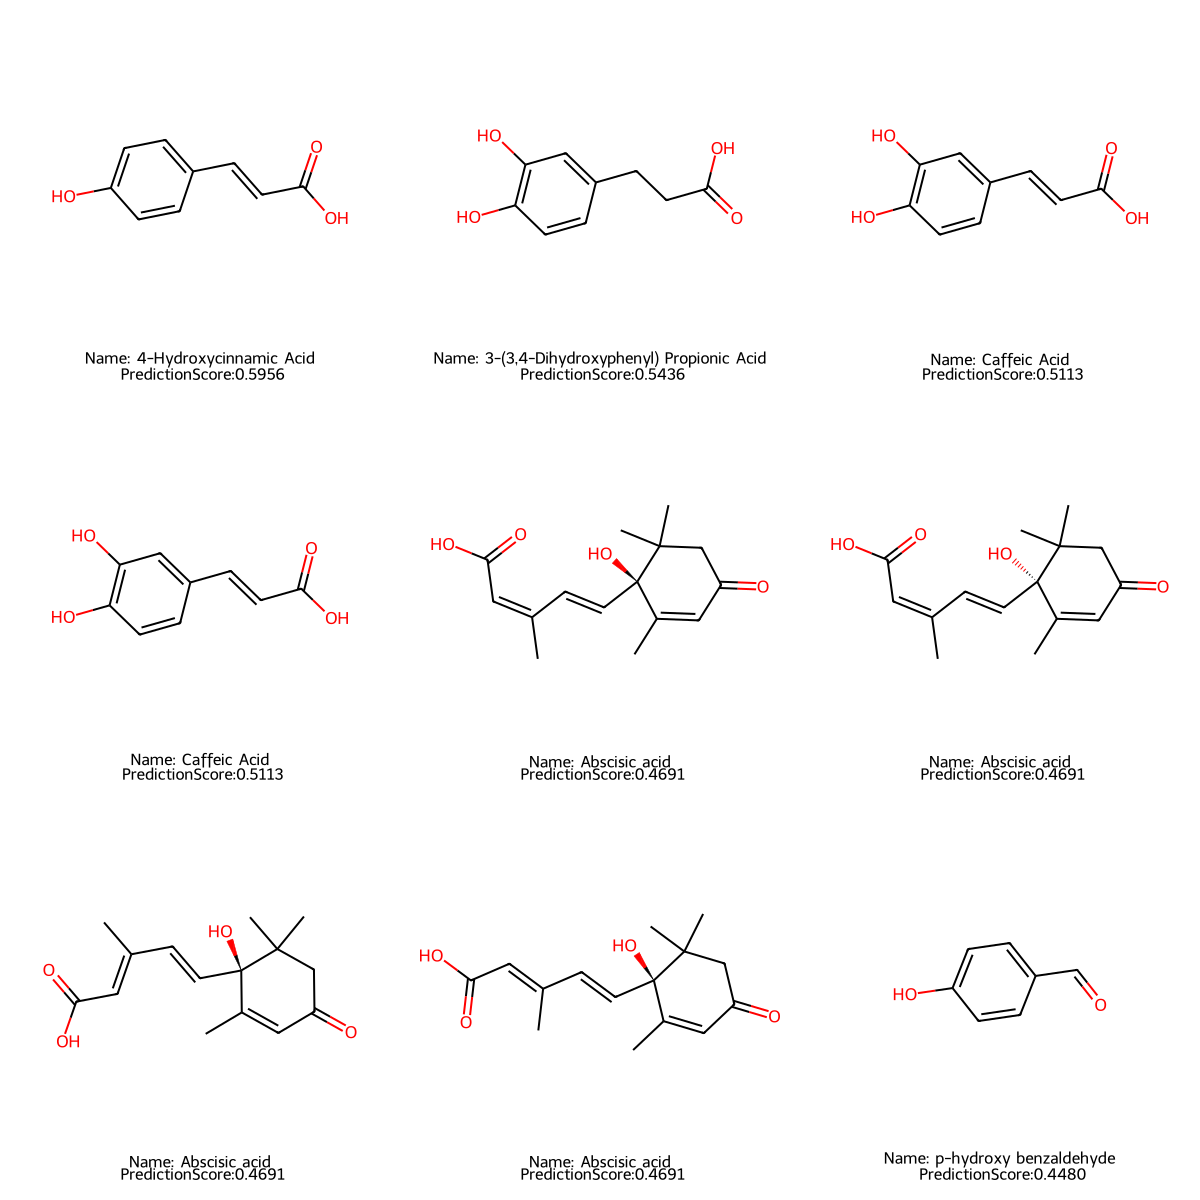

In [166]:
from rdkit import Chem
from rdkit.Chem import Draw

# Lengend is a combination of iupc name and atc code. Break them into multiple lines for drawing 
# I could not find atc code for all of them. 
def genLegend(c):
    # c is a tuple <compound, level4AtcCode>
    #return c[0].iupac_name[0:60] + "\n" + c[0].iupac_name[61:120] + "\n" + c[0].iupac_name[121:180] + "\n" + c[0].iupac_name[181:] + "\n" \
    #    + "\n" + "model score: " + str(c[1][1])
    return "Name: {}\n PredictionScore:{:.4f}".format(prediction_compounds_to_name[c[0].iupac_name], c[1][1])
    
zipped = list(zip(prediction_compounds, Y_pred))
sorted_zipped = sorted(zipped, key=lambda x: -x[1][1])
    
names = [genLegend(c) for c in sorted_zipped]
#names = [c.synonyms for c in positive_compounds]
molecules = [getRdkitMoleculeFromPubChemCompound(c[0]) for c in sorted_zipped]
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(400, 400), legends=names, maxMols = 9, returnPNG=False)
print(names[0:10])

img.save("molecule_grid_acne_9_compound.png")

img

# END